# Week 3: Model-Free Prediction and Control

## Overview

This week, we explore **Model-Free** learning methods—approaches that don't require knowledge of the environment's dynamics. We learn directly from experience by sampling episodes and updating value estimates.

### Key Concepts

- **Model-Free vs Model-Based**: We don't have a transition model P(s'|s,a) or reward function R(s,a). We learn from samples.
- **On-Policy vs Off-Policy**: 
  - **On-Policy**: Learn from the policy you're following (SARSA)
  - **Off-Policy**: Learn from one policy while following another (Q-Learning)


## Part 1: Model-Free Learning Methods

### 1. **Monte Carlo (MC)**

**Idea**: Learn value estimates from complete episodes by averaging sampled returns.

- **Update Rule**: After episode ends, for each state visited, update:
  $$V(s) \leftarrow V(s) + \alpha [G_t - V(s)]$$
  where $G_t$ is the total discounted return from time $t$ onwards.

- **Properties**:
  - **Variance**: High (we wait for the full episode)
  - **Bias**: Zero (based on actual returns)
  - **Requires**: Complete episodes (terminal states)
  - **Best for**: Problems with fast simulations, high variance okay

---

### 2. **Temporal Difference (TD)**

**Idea**: Learn from incomplete episodes by **bootstrapping**—updating a guess based on another guess.

- **Update Rule** (TD(0)):
  $$V(s) \leftarrow V(s) + \alpha [r + \gamma V(s') - V(s)]$$
  where $\delta_t = r + \gamma V(s') - V(s)$ is the **TD Error**.

- **Properties**:
  - **Variance**: Lower than MC (immediate updates)
  - **Bias**: Biased (depends on bootstrap estimate)
  - **Sample Efficiency**: Better than MC (update at every step)
  - **Best for**: Real-time learning, streaming data

---

### 3. **SARSA (State-Action-Reward-State-Action)**

**Type**: On-Policy TD Control Algorithm

- **Idea**: Learn the Q-value of actions while following the current policy. The next Q-value used for bootstrapping comes from the **actual action taken** by the policy.

- **Update Rule**:
  $$Q(s, a) \leftarrow Q(s, a) + \alpha [r + \gamma Q(s', a') - Q(s, a)]$$
  where $a'$ is the action **actually taken** in state $s'$ (from the current policy).

- **Behavior**: 
  - **Conservative**: Learns to avoid dangerous states (e.g., cliff edges)
  - **Safe**: Respects the exploratory actions it might take
  - **Suitable**: When exploration is risky

---

### 4. **Q-Learning**

**Type**: Off-Policy TD Control Algorithm

- **Idea**: Learn the optimal Q-value by always assuming the **best possible future action**, regardless of which action the current policy actually takes.

- **Update Rule**:
  $$Q(s, a) \leftarrow Q(s, a) + \alpha [r + \gamma \max_{a'} Q(s', a') - Q(s, a)]$$
  where $\max_{a'} Q(s', a')$ is the **maximum Q-value** over all possible next actions.

- **Behavior**:
  - **Greedy**: Learns the optimal policy while exploring sub-optimally
  - **Optimal**: Converges to the optimal policy even if it takes risky actions during learning
  - **Suitable**: When we want the best policy, and exploration cost is tolerable

---

### **Key Difference: SARSA vs Q-Learning**

In the **Cliff Walking** problem:
- **SARSA**: Learns to walk along the edge of the cliff (safe path) because it considers its exploratory actions.
- **Q-Learning**: Learns the optimal path close to the cliff because it only looks at the best future actions.


## Part 2: Implementation - Cliff Walking (Sutton & Barto, Example 6.6)

### Problem Setup

**Grid**: 4 rows × 12 columns
- **Start**: (3, 0) — bottom-left
- **Goal**: (3, 11) — bottom-right
- **Cliff**: (3, 1) to (3, 10) — the dangerous row
- **Rewards**: -100 for cliff (resets to start), -1 for all other steps

The agent must navigate from start to goal while avoiding the cliff. SARSA and Q-Learning will learn different strategies due to their on-policy vs off-policy nature.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

class CliffWalkingEnv:
    """
    Sutton & Barto Example 6.6: Cliff Walking
    
    Grid: 4 rows x 12 columns
    Start: (3, 0)
    Goal: (3, 11)
    Cliff: (3, 1) to (3, 10)
    """
    
    def __init__(self):
        self.rows, self.cols = 4, 12
        self.start_pos = (3, 0)
        self.goal_pos = (3, 11)
        self.current_pos = self.start_pos
        
        # Define cliff positions
        self.cliff = set((3, i) for i in range(1, 11))
        
    def reset(self):
        """Reset agent to start position."""
        self.current_pos = self.start_pos
        return self.current_pos
    
    def step(self, action):
        """
        Take action: 0=up, 1=down, 2=left, 3=right
        Returns: (next_state, reward, done)
        """
        row, col = self.current_pos
        
        # Move based on action
        if action == 0:  # up
            row = max(0, row - 1)
        elif action == 1:  # down
            row = min(self.rows - 1, row + 1)
        elif action == 2:  # left
            col = max(0, col - 1)
        elif action == 3:  # right
            col = min(self.cols - 1, col + 1)
        
        self.current_pos = (row, col)
        
        # Check reward and terminal state
        reward = -1  # Default step cost
        done = False
        
        if self.current_pos in self.cliff:
            reward = -100  # Cliff penalty
            self.current_pos = self.start_pos  # Reset to start
        elif self.current_pos == self.goal_pos:
            done = True  # Reached goal
        
        return self.current_pos, reward, done
    
    def render(self, policy=None):
        """Visualize the grid with optionally the learned policy."""
        grid = np.zeros((self.rows, self.cols))
        
        # Mark cliff
        for cliff_pos in self.cliff:
            grid[cliff_pos] = -1
        
        # Mark start and goal
        grid[self.start_pos] = 2
        grid[self.goal_pos] = 3
        
        plt.figure(figsize=(12, 4))
        plt.imshow(grid, cmap='RdYlGn', aspect='auto')
        plt.colorbar(label='Value')
        
        if policy is not None:
            # Draw arrows for policy
            action_symbols = ['↑', '↓', '←', '→']
            for r in range(self.rows):
                for c in range(self.cols):
                    if (r, c) not in self.cliff and (r, c) != self.goal_pos:
                        best_action = policy.get((r, c), 0)
                        plt.text(c, r, action_symbols[best_action], 
                                ha='center', va='center', fontsize=12, 
                                fontweight='bold', color='black')
        
        plt.title('Cliff Walking Grid')
        plt.xlabel('Column')
        plt.ylabel('Row')
        plt.tight_layout()
        plt.show()

# Test the environment
env = CliffWalkingEnv()
state = env.reset()
print(f"Start state: {state}")

# Take a few random steps
for i in range(5):
    action = np.random.randint(0, 4)
    next_state, reward, done = env.step(action)
    print(f"Step {i+1}: Action {action} -> State {next_state}, Reward {reward}, Done {done}")
    if done:
        env.reset()


Start state: (3, 0)
Step 1: Action 1 -> State (3, 0), Reward -1, Done False
Step 2: Action 1 -> State (3, 0), Reward -1, Done False
Step 3: Action 1 -> State (3, 0), Reward -1, Done False
Step 4: Action 0 -> State (2, 0), Reward -1, Done False
Step 5: Action 2 -> State (2, 0), Reward -1, Done False


In [2]:
class SARSAAgent:
    """
    SARSA: State-Action-Reward-State-Action (On-Policy TD Control)
    
    Update Rule:
    Q(s,a) ← Q(s,a) + α[r + γQ(s',a') - Q(s,a)]
    where a' is the action actually taken from the next state
    """
    
    def __init__(self, num_actions=4, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.num_actions = num_actions
        self.alpha = alpha          # Learning rate
        self.gamma = gamma          # Discount factor
        self.epsilon = epsilon      # Exploration rate
        self.Q = defaultdict(lambda: np.zeros(num_actions))
    
    def select_action(self, state, training=True):
        """ε-greedy action selection."""
        if training and np.random.random() < self.epsilon:
            return np.random.randint(self.num_actions)
        else:
            return np.argmax(self.Q[state])
    
    def update(self, state, action, reward, next_state, next_action, done):
        """SARSA update: uses the action actually taken in next state."""
        if done:
            target = reward
        else:
            target = reward + self.gamma * self.Q[next_state][next_action]
        
        td_error = target - self.Q[state][action]
        self.Q[state][action] += self.alpha * td_error
    
    def get_policy(self):
        """Extract greedy policy from Q-values."""
        policy = {}
        for state in self.Q:
            policy[state] = np.argmax(self.Q[state])
        return policy

# Test SARSA agent
agent = SARSAAgent()
print("SARSA Agent initialized with Q-table:", dict(agent.Q))


SARSA Agent initialized with Q-table: {}


In [3]:
class QLearningAgent:
    """
    Q-Learning: Off-Policy TD Control
    
    Update Rule:
    Q(s,a) ← Q(s,a) + α[r + γ max_a' Q(s',a') - Q(s,a)]
    where max_a' is the BEST action in the next state (not the actual action taken)
    """
    
    def __init__(self, num_actions=4, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.num_actions = num_actions
        self.alpha = alpha          # Learning rate
        self.gamma = gamma          # Discount factor
        self.epsilon = epsilon      # Exploration rate
        self.Q = defaultdict(lambda: np.zeros(num_actions))
    
    def select_action(self, state, training=True):
        """ε-greedy action selection."""
        if training and np.random.random() < self.epsilon:
            return np.random.randint(self.num_actions)
        else:
            return np.argmax(self.Q[state])
    
    def update(self, state, action, reward, next_state, done):
        """Q-Learning update: uses the BEST action in next state."""
        if done:
            target = reward
        else:
            # Key difference: max over all actions, not the actual action taken
            target = reward + self.gamma * np.max(self.Q[next_state])
        
        td_error = target - self.Q[state][action]
        self.Q[state][action] += self.alpha * td_error
    
    def get_policy(self):
        """Extract greedy policy from Q-values."""
        policy = {}
        for state in self.Q:
            policy[state] = np.argmax(self.Q[state])
        return policy

# Test Q-Learning agent
agent = QLearningAgent()
print("Q-Learning Agent initialized with Q-table:", dict(agent.Q))


Q-Learning Agent initialized with Q-table: {}


In [7]:
def train_sarsa(env, agent, num_episodes=500, max_steps=100):
    """Train SARSA agent and return episode rewards."""
    episode_rewards = []
    
    for episode in range(num_episodes):
        state = env.reset()
        action = agent.select_action(state, training=True)
        episode_reward = 0
        
        for step in range(max_steps):
            # Take action
            next_state, reward, done = env.step(action)
            next_action = agent.select_action(next_state, training=True)
            
            # SARSA update
            agent.update(state, action, reward, next_state, next_action, done)
            
            episode_reward += reward
            state = next_state
            action = next_action
            
            if done:
                break
        
        episode_rewards.append(episode_reward)
        
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            print(f"SARSA - Episode {episode + 1}, Avg Reward (last 100): {avg_reward:.2f}")
    
    return episode_rewards

def train_qlearning(env, agent, num_episodes=500, max_steps=100):
    """Train Q-Learning agent and return episode rewards."""
    episode_rewards = []
    
    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        
        for step in range(max_steps):
            # Take action (ε-greedy)
            action = agent.select_action(state, training=True)
            next_state, reward, done = env.step(action)
            
            # Q-Learning update
            agent.update(state, action, reward, next_state, done)
            
            episode_reward += reward
            state = next_state
            
            if done:
                break
        
        episode_rewards.append(episode_reward)
        
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            print(f"Q-Learning - Episode {episode + 1}, Avg Reward (last 100): {avg_reward:.2f}")
    
    return episode_rewards

# Train both agents
print("Training SARSA agent...")
env_sarsa = CliffWalkingEnv()
sarsa_agent = SARSAAgent(alpha=0.1, gamma=1.0, epsilon=0.1)
sarsa_rewards = train_sarsa(env_sarsa, sarsa_agent, num_episodes=500)

print("\nTraining Q-Learning agent...")
env_qlearning = CliffWalkingEnv()
qlearning_agent = QLearningAgent(alpha=0.1, gamma=1.0, epsilon=0.1)
qlearning_rewards = train_qlearning(env_qlearning, qlearning_agent, num_episodes=500)


Training SARSA agent...
SARSA - Episode 100, Avg Reward (last 100): -118.53
SARSA - Episode 200, Avg Reward (last 100): -54.07
SARSA - Episode 300, Avg Reward (last 100): -35.09
SARSA - Episode 400, Avg Reward (last 100): -24.57
SARSA - Episode 500, Avg Reward (last 100): -19.36

Training Q-Learning agent...
Q-Learning - Episode 100, Avg Reward (last 100): -126.10
Q-Learning - Episode 200, Avg Reward (last 100): -62.89
Q-Learning - Episode 300, Avg Reward (last 100): -57.09
Q-Learning - Episode 400, Avg Reward (last 100): -36.51
Q-Learning - Episode 500, Avg Reward (last 100): -46.84


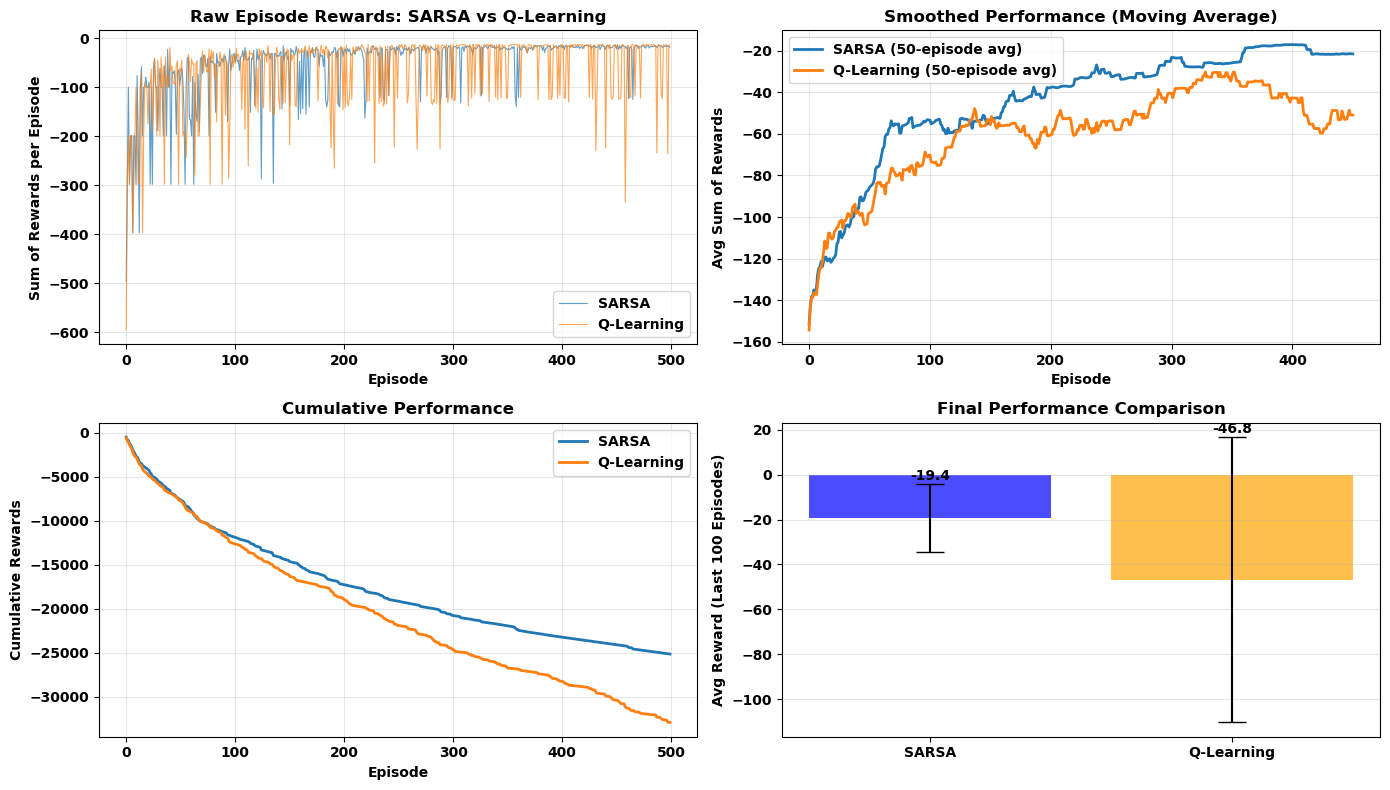


TRAINING RESULTS

SARSA (On-Policy):
  Final 100 episodes avg reward: -19.36
  Final 100 episodes std dev: 15.12
  Total cumulative reward: -25162.00

Q-Learning (Off-Policy):
  Final 100 episodes avg reward: -46.84
  Final 100 episodes std dev: 63.59
  Total cumulative reward: -32943.00

INTERPRETATION

SARSA typically shows:
  • Lower average rewards (takes cautious path away from cliff)
  • More stable/consistent performance (less variance)
  • Learns a "safe" policy

Q-Learning typically shows:
  • Higher average rewards (learns optimal path near cliff)
  • More variable performance during training
  • Eventually learns the true optimal policy

The difference arises because:
  • SARSA: On-policy → considers its exploratory actions in updates
  • Q-Learning: Off-policy → ignores exploration, learns best possible path



In [8]:
# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Plot 1: Raw rewards per episode
ax = axes[0, 0]
ax.plot(sarsa_rewards, label='SARSA', alpha=0.7, linewidth=0.8)
ax.plot(qlearning_rewards, label='Q-Learning', alpha=0.7, linewidth=0.8)
ax.set_xlabel('Episode')
ax.set_ylabel('Sum of Rewards per Episode')
ax.set_title('Raw Episode Rewards: SARSA vs Q-Learning')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Smoothed rewards (moving average)
ax = axes[0, 1]
window = 50
sarsa_smooth = np.convolve(sarsa_rewards, np.ones(window)/window, mode='valid')
qlearning_smooth = np.convolve(qlearning_rewards, np.ones(window)/window, mode='valid')
ax.plot(sarsa_smooth, label='SARSA (50-episode avg)', linewidth=2)
ax.plot(qlearning_smooth, label='Q-Learning (50-episode avg)', linewidth=2)
ax.set_xlabel('Episode')
ax.set_ylabel('Avg Sum of Rewards')
ax.set_title('Smoothed Performance (Moving Average)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Cumulative rewards
ax = axes[1, 0]
sarsa_cumsum = np.cumsum(sarsa_rewards)
qlearning_cumsum = np.cumsum(qlearning_rewards)
ax.plot(sarsa_cumsum, label='SARSA', linewidth=2)
ax.plot(qlearning_cumsum, label='Q-Learning', linewidth=2)
ax.set_xlabel('Episode')
ax.set_ylabel('Cumulative Rewards')
ax.set_title('Cumulative Performance')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Statistics comparison
ax = axes[1, 1]
labels = ['SARSA', 'Q-Learning']
means = [np.mean(sarsa_rewards[-100:]), np.mean(qlearning_rewards[-100:])]
stds = [np.std(sarsa_rewards[-100:]), np.std(qlearning_rewards[-100:])]

x = np.arange(len(labels))
ax.bar(x, means, yerr=stds, capsize=10, alpha=0.7, color=['blue', 'orange'])
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Avg Reward (Last 100 Episodes)')
ax.set_title('Final Performance Comparison')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (mean, std) in enumerate(zip(means, stds)):
    ax.text(i, mean + std + 2, f'{mean:.1f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Print statistics
print("\n" + "="*60)
print("TRAINING RESULTS")
print("="*60)
print(f"\nSARSA (On-Policy):")
print(f"  Final 100 episodes avg reward: {np.mean(sarsa_rewards[-100:]):.2f}")
print(f"  Final 100 episodes std dev: {np.std(sarsa_rewards[-100:]):.2f}")
print(f"  Total cumulative reward: {np.sum(sarsa_rewards):.2f}")

print(f"\nQ-Learning (Off-Policy):")
print(f"  Final 100 episodes avg reward: {np.mean(qlearning_rewards[-100:]):.2f}")
print(f"  Final 100 episodes std dev: {np.std(qlearning_rewards[-100:]):.2f}")
print(f"  Total cumulative reward: {np.sum(qlearning_rewards):.2f}")

print("\n" + "="*60)
print("INTERPRETATION")
print("="*60)
print("""
SARSA typically shows:
  • Lower average rewards (takes cautious path away from cliff)
  • More stable/consistent performance (less variance)
  • Learns a "safe" policy

Q-Learning typically shows:
  • Higher average rewards (learns optimal path near cliff)
  • More variable performance during training
  • Eventually learns the true optimal policy

The difference arises because:
  • SARSA: On-policy → considers its exploratory actions in updates
  • Q-Learning: Off-policy → ignores exploration, learns best possible path
""")



SARSA Learned Policy:


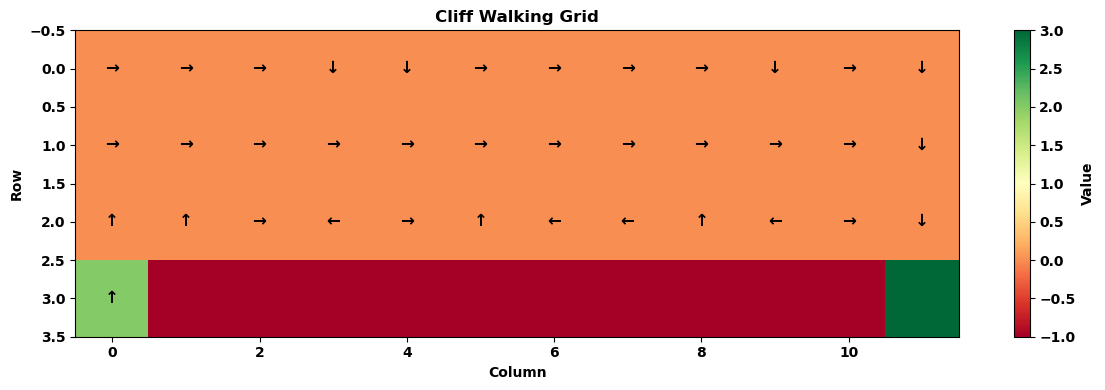


Q-Learning Learned Policy:


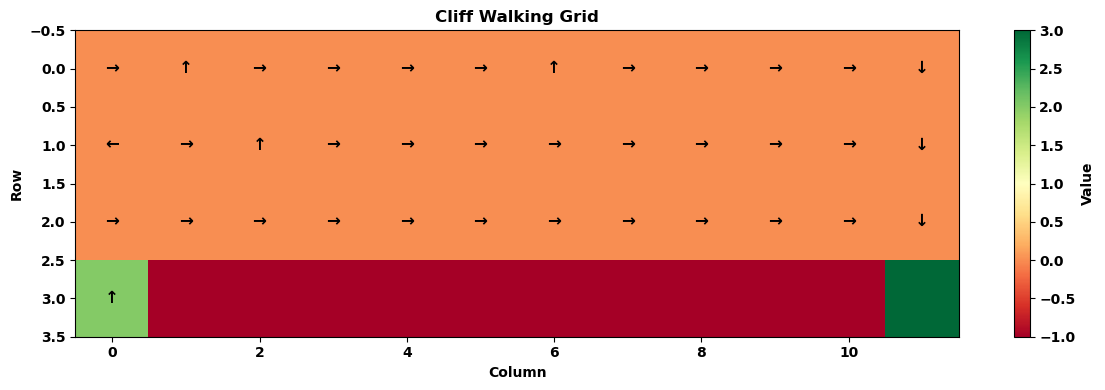


POLICY EVALUATION (Testing on 10 episodes)

SARSA avg reward per episode: -15.00
Q-Learning avg reward per episode: -13.00

Most visited states (SARSA): [((3, 0), 10), ((2, 0), 10), ((1, 0), 10), ((1, 1), 10), ((1, 2), 10)]
Most visited states (Q-Learning): [((3, 0), 10), ((2, 0), 10), ((2, 1), 10), ((2, 2), 10), ((2, 3), 10)]


In [9]:
# Visualize learned policies
print("\nSARSA Learned Policy:")
sarsa_policy = sarsa_agent.get_policy()
env_sarsa.render(policy=sarsa_policy)

print("\nQ-Learning Learned Policy:")
qlearning_policy = qlearning_agent.get_policy()
env_qlearning.render(policy=qlearning_policy)

# Compare paths taken by both policies
def evaluate_policy(env, agent, num_episodes=10):
    """Evaluate the agent's learned policy (no exploration)."""
    total_rewards = 0
    path_count = defaultdict(int)
    
    for _ in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        
        while True:
            action = agent.select_action(state, training=False)
            path_count[state] += 1
            next_state, reward, done = env.step(action)
            episode_reward += reward
            state = next_state
            
            if done:
                break
        
        total_rewards += episode_reward
    
    return total_rewards / num_episodes, path_count

print("\n" + "="*60)
print("POLICY EVALUATION (Testing on 10 episodes)")
print("="*60)

sarsa_avg, sarsa_path = evaluate_policy(env_sarsa, sarsa_agent)
qlearning_avg, qlearning_path = evaluate_policy(env_qlearning, qlearning_agent)

print(f"\nSARSA avg reward per episode: {sarsa_avg:.2f}")
print(f"Q-Learning avg reward per episode: {qlearning_avg:.2f}")

# Show which cells are visited most
print(f"\nMost visited states (SARSA): {sorted(sarsa_path.items(), key=lambda x: x[1], reverse=True)[:5]}")
print(f"Most visited states (Q-Learning): {sorted(qlearning_path.items(), key=lambda x: x[1], reverse=True)[:5]}")


## Summary: Key Takeaways

### Algorithm Comparison

| Aspect | SARSA | Q-Learning |
|--------|-------|-----------|
| **Policy Type** | On-Policy | Off-Policy |
| **Update Uses** | Actual next action | Best next action |
| **Safety** | Conservative, safe | Optimal but risky |
| **Variance** | Lower (more stable) | Higher (more explorative) |
| **Convergence** | Slower to optimal | Faster to optimal |
| **Cliff Walking Path** | Away from edge | Along edge (optimal) |

### Why the Differences?

- **SARSA**: Learns the value of following its current (exploratory) policy. Since the policy includes random actions, SARSA penalizes paths that might accidentally go near the cliff.
  
- **Q-Learning**: Learns the value assuming the best possible actions in the future, regardless of current exploration. It "optimistically" assumes you'll be smart next time, so it's willing to risk the edge if it's shorter.

### Practical Applications

- **SARSA**: Robot navigation, safety-critical systems (we want the safest policy given our exploration)
- **Q-Learning**: Game AI, offline learning (we want the best possible policy regardless of how we explored)

### Further Exploration

Try modifying:
1. **Learning rate (α)**: How quickly do they adapt?
2. **Exploration rate (ε)**: Decaying exploration over time?
3. **Discount factor (γ)**: How far-sighted are the agents?
4. **GridWorld size/cliff shape**: Different problems, different strategies


For a more complex problem, [Cart Pole](https://gymnasium.farama.org/environments/classic_control/cart_pole ), it is implemented using Q-Learning in the 'cartpole' folder.